
# Global Parameters of the Notebook

## Paths

- Parameters related to data / model / lib paths

In [1]:
# Lib to define paths
import os

# Define if we are running the notebook in our computer ("local")
# or in Google Colab ("remote")
RUNNING_ENV = "remote"

# Base path for the rest of paths defined in the notebook
BASE_PATH = "./" if RUNNING_ENV == "local" else "/content/drive/MyDrive/Colab Notebooks/"

# Path to our lib dir
LIB_PATH = os.path.join(BASE_PATH, "lib")

# Path where we store training / test data
DATA_PATH = os.path.join(BASE_PATH, "data")

# Dir with all cached models 
# This cached models can be loaded from disk when training is skipped
MODEL_CACHE_FOLDER = os.path.join(BASE_PATH, "cached_models")

## ML parameters

- Parameters related to machine learning
- For example, batch sizes, learning rates, ...

### Offline parameters

- Parameters related to offline training using random triplets

In [2]:
# Batch size for offline training
OFFLINE_BATCH_SIZE = 32

# Size of random triplets sets
# It has to be a multiple of `OFFLINE_BATCH_SIZE`, so the network
# has batches of proper size
RANDOM_TRIPLETS_DATA_SIZE = OFFLINE_BATCH_SIZE * 15

# Training epochs for the random triplets model
TRAINING_EPOCHS_RANDOM = 10

# Learning rate for random triplets model
RANDOM_TRIPLET_LEARNING_RATE = 0.001

# How many single elements we want to see before logging 
# It has to be a multiple of `OFFLINE_BATCH_SIZE`, otherwise `should_log` would 
# return always false
OFFLINE_LOGGING_ITERATIONS = OFFLINE_BATCH_SIZE * 5

### Online parameters 

- Parameters related to online training, using P-K sampling

In [3]:
# Parameters of P-K sampling
P = 3   # Number of classes used in each minibatch
K = 32  # Number of images sampled for each selected class

# Batch size for online training 
# We can use `P * K` as batch size. Thus, minibatches will be
# as we expect in P-K sampling. 
# 
# But we can use `n * P * K`. Thus, minibatches will be n P-K sampling
# minibatche concatenated together
# Be careful when doing this because it can be really slow, and there is no
# clear reason to do this
ONLINE_BATCH_SIZE = P * K

# Epochs for hard triplets, online training 
TRAINING_EPOCHS = 1

# Learning rate for hard triplets, online training
ONLINE_LEARNING_RATE = 0.1

# How many single elements we want to see before logging 
# It has to be a multiple of P * K, otherwise `should_log` would return always 
# false as `it % LOGGING_ITERATIONS != 0` always
#
# `LOGGING_ITERATIONS = P * K * n` means we log after seeing `n` P-K sampled
# minibatches
LOGGING_ITERATIONS = P * K * 20

# Which percentage of the training and validation set we want to use for the logging
ONLINE_LOGGER_TRAIN_PERCENTAGE = 0.01
ONLINE_LOGGER_VALIDATION_PERCENTAGE = 0.01

### Shared parameters

- Parameters used in both offline and online training
- Or parameters that has nothing to do with that

In [4]:
# Epochs used in k-Fold Cross validation 
# k-Fold Cross validation used for parameter exploration
HYPERPARAMETER_TUNING_EPOCHS = 7

# Number of folds used in k-fold Cross Validation
NUMBER_OF_FOLDS = 4

# Margin used in the loss function
MARGIN = 10.0

# Dim of the embedding calculated by the network
EMBEDDING_DIMENSION = 3

# Number of neighbours considered in K-NN
# K-NN used for transforming embedding task to classification task 
NUMBER_NEIGHBOURS = 3

# Batch Triplet Loss Function
# This way we can choose among "hard", "all"
BATCH_TRIPLET_LOSS_FUNCTION = "all"

# Wether or not use softplus loss function instead of vanilla triplet loss
USE_SOFTPLUS_LOSS = False

# Count all sumamnds in the mean loss or only those summands greater than zero
USE_GT_ZERO_MEAN_LOSS = True

## Section parameters

- Flags to choose if some sections will run or not
- This way we can skip some heavy computations when not needed 

In [5]:
# Skip the training using random triplets 
SKIP_RANDOM_TRIPLETS_TRAINING = True

# Skip hyper parameter tuning for online training
SKIP_HYPERPARAMTER_TUNING = True

# Skip training and use a cached model
# Useful for testing the embedding -> classifier transformation
# Thus, when False training is not computed and a cached model
# is loaded from disk
# Cached models are stored in `MODEL_CACHE_FOLDER`
USE_CACHED_MODEL = False

## Others

In [6]:
# Number of workers we want to use 
# We can have less, equal or greater num of workers than CPUs
# In the following forum:
#   https://discuss.pytorch.org/t/guidelines-for-assigning-num-workers-to-dataloader/813/4
# they recomend to explore this parameter, growing it until system RAM saturates
NUM_WORKERS = 8

# Fix random seed to make reproducible results
RANDOM_SEED = 123456789

# Auth forGoogle Drive

In [7]:
if RUNNING_ENV == "remote":
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing the modules we are going to use

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets

# For using pre-trained ResNets
import torchvision.models as models 
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from pprint import pprint
import gc
import functools
import math
import seaborn as sns

# All concrete pieces we're using form sklearn
from sklearn.metrics import roc_auc_score, accuracy_score, silhouette_score
from sklearn.model_selection import ShuffleSplit

from typing import List

# Load in the notebook all .py files that make our personal lib
# This way we keep notebook code as small as possible, and only pertinent 
# to the concrete task that this notebook solves (generic and reusable code
# goes to personal lib)
!cp -r "$LIB_PATH"/* .

# Now that files are loaded, we can import pieces of code
import core
import trainers
import time
import copy
import board
import filesystem
import metrics
import loss_functions
import embedding_to_classifier
import sampler

from trainers import train_model_offline, train_model_online
from train_loggers import ClassificationLogger, SilentLogger, TripletLoggerOffline, TripletLoggerOnline, TrainLogger
from models import *
from visualizations import *
from tqdm.notebook import tqdm
from models import ResNet18
from loss_functions import MeanTripletBatchTripletLoss, BatchHardTripletLoss, BatchAllTripletLoss
from embedding_to_classifier import EmbeddingToClassifier
from sampler import CustomSampler

# Functions that we are going to use

In [9]:
def show_learning_curve(training_history: dict):
    # Take two learning curves
    loss = training_history['loss']
    val_loss = training_history['val_loss']

    # Move the lists to cpu, because that's what matplotlib needs
    loss = [loss_el.cpu() for loss_el in loss]
    val_loss = [val_loss_el.cpu() for val_loss_el in val_loss]
    
    # Show graphics
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.show()
    
def try_to_clean_memory(): 
    torch.cuda.empty_cache() 
    gc.collect()

# Random Triplets 

- In this section, we are going to work with random triplets
- If minibatch size is $3\times n$, then:
    - Select a random element. For that element, select a random anchor and a random negative
    - Add this triple to the minibatch
    - Repeat the process $n$ times
- We use this model (determined heavily by the sampling method) as a baseline for more sophisticated models (determined heavily by more sophisticated sampling methods)

## Dataset loading

- Load training / test data
- Split training in train / validation

In [10]:
# Transformations that we want to apply when loading the data
# Now we are only transforming images to tensors (pythorch only works with tensors)
# But we can apply here some normalizations
transform = transforms.Compose([
    transforms.ToTensor()
    # TODO -- apply some normalizations here
])

# Load the dataset
# torchvision has a method to download and load the dataset
train_dataset = torchvision.datasets.MNIST(
    root = DATA_PATH,
    train = True,
    download = True,
    transform = transform,
)

test_dataset = torchvision.datasets.MNIST(
    root = DATA_PATH,
    train = False,
    download = True,
    transform = transform,
)

# Train -> train / validation split
train_dataset, validation_dataset = core.split_train_test(train_dataset, 0.8)

# Data loaders to access the datasets
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = OFFLINE_BATCH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS,
    pin_memory = True,
)

validation_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size = OFFLINE_BATCH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS,
    pin_memory = True,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = OFFLINE_BATCH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS,
    pin_memory = True,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Exploratory Data Analysis

Show some images with their classes, to verify that data loading was properly done:

Img class is: 6


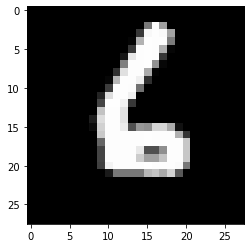

Img class is: 3


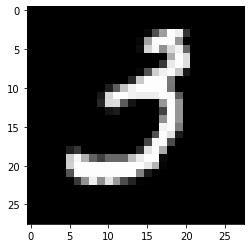

Img class is: 4


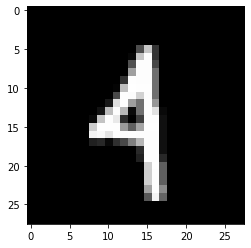

Img class is: 2


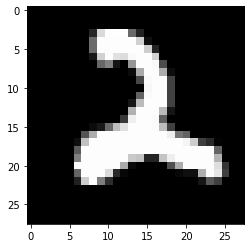

Img class is: 1


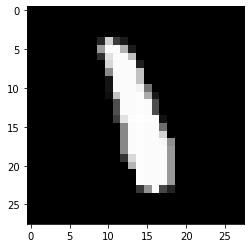

In [11]:
imgs_to_show = 5

for _ in range(imgs_to_show):

    # Cargamos un batch de imagenes
    images, images_classes = next(iter(train_loader))

    # Nos quedamos con la primera imagen del batch
    img, img_class = images[0], images_classes[0]

    # Mostramos alguna informacion de la imagen
    print(f"Img class is: {img_class}")

    # Re-escalamos y mostramos la imagen
    img = img.reshape((28, 28))
    show_img(img, color_format_range = (-1.0, 1.0))

Show the sizes of the datasets

In [12]:
print(f"Train dataset: {len(train_dataset)}")
print(f"Validation dataset: {len(validation_dataset)}")
print(f"Test dataset: {len(test_dataset)}")

Train dataset: 48000
Validation dataset: 12000
Test dataset: 10000


## Random triplets generation

- For training the siamese network, we need triplets for computing *triplet loss*
- One simple way of generating triplets is randomly creating triplets (as explained before) in an offline fashion
    - Created a dataset of random triplets beforehand
    - With fixed elements 
- Later, we are going to generate triplets in an online fashion with more sophisticated methods
- In this case, we create a *pytorch* `Dataset` class, following the [official documentation]](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [13]:
from torch.utils.data import RandomSampler

# TODO -- change attr names to english ones
class RandomTriplets(Dataset):
    """
    Dataset where elements are random triplets
    """

    def __init__(self, base_data: Dataset, custom_len: int, transform = None):
        self.base_data = base_data
        self.custom_len = custom_len
        self.transform = transform
        self.random_sampler = RandomSampler(self.base_data, replacement=True, num_samples=1, generator=None)
        
        # For speeding things up, we can pre-compute a list of lists, such that
        # self.posiciones_clases[i] has all the indixes of elements corresponding 
        # to i-th class
        self.posiciones_clases = self.__precompute_list_of_classes()

    def __len__(self) -> int:
        """
        We are generating random triplets. WAe have an attr that defines
        how many triplets we want, so we return that value
        """
        return self.custom_len

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """       
        Function which is called when using `dataset[idx]`
        
        Instead of returning an image, which is the common behavior, we return 
        a triplet (anchor, positive, negative)
        """

        # Speed up computations
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Take a random class, which will act as anchor
        anchor, anchor_class = self.base_data[next(iter(self.random_sampler))]

        # Take a random image of the same class
        # Thus, this image will be the anchor
        random_index = np.random.choice(self.posiciones_clases[anchor_class])
        positive, positive_class = self.base_data[random_index]

        # Take a random image of other class
        # Start taking a class that is not the same as the anchor class
        posible_classes = list(range(10))
        posible_classes.remove(anchor_class)
        negative_class = np.random.choice(posible_classes)

        # Take a random image of that negative class selected before
        random_index = np.random.choice(self.posiciones_clases[negative_class])
        negative, negative_class = self.base_data[random_index]
        
        # Pack up the triplet
        triplet = [anchor, positive, negative]

        # Apply the dataset transformation to the three images 
        if self.transform:
            triplet = [self.transform(np.array(img)) for img in triplet]

        return triplet

    def __precompute_list_of_classes(self) -> List[List[int]]:
        """
        Computes a list containing list. Each list contains the positions of elements of given class
        ie. class_positions[i] contains all positions of elements of i-th class
        """

        # Init the list of lists
        posiciones_clases = [[] for _ in range(10)]

        # Walk the dataset and assign each element to its corresponding class
        for idx, element in enumerate(self.base_data):
            _, img_class = element
            posiciones_clases[img_class].append(idx)

        return posiciones_clases

    
class CustomReshape(object):
    """
    Transform an (28, 1, 28) img to an (28, 28) img
    """

    def __call__(self, image):
        image = image.reshape(28, 28)
        return image

In [14]:
# Check if we want to skip this section 
if SKIP_RANDOM_TRIPLETS_TRAINING is False:
   
    # Reshape images from (28, 1, 28) to (28, 28)
    transform = transforms.Compose([
        # Move images to torch tensors that are needed for pytorch
        transforms.ToTensor(),
            
        # Use our custom reshape
        CustomReshape(),
    ])

    # Generate a dataset with the random triplets and use it 
    # on a dataloader, for train, validation and test original 
    # datasets 
    random_triplets_train = RandomTriplets(
        base_data = train_dataset,
        custom_len = RANDOM_TRIPLETS_DATA_SIZE,
        transform = transform,
    )
    train_loader = torch.utils.data.DataLoader(
        random_triplets_train,
        batch_size = OFFLINE_BATCH_SIZE,
        shuffle = True,
        num_workers = NUM_WORKERS,
        pin_memory = True,
    )

    random_triplets_validation = RandomTriplets(
        base_data = validation_dataset,
        custom_len = RANDOM_TRIPLETS_DATA_SIZE,
        transform = transform,
    )
    validation_loader = torch.utils.data.DataLoader(
        random_triplets_validation,
        batch_size = OFFLINE_BATCH_SIZE,
        shuffle = True,
        num_workers = NUM_WORKERS,
        pin_memory = True,
    )

    random_triplets_test = RandomTriplets(
        base_data = test_dataset,
        custom_len = RANDOM_TRIPLETS_DATA_SIZE,
        transform = transform,
    )
    test_loader = torch.utils.data.DataLoader(
        random_triplets_test,
        batch_size = OFFLINE_BATCH_SIZE,
        shuffle = True,
        num_workers = NUM_WORKERS,
        pin_memory = True,
    )

    # Show some triplets to check behaviour
    custom_triplet = random_triplets_train[2]
    for i in custom_triplet :
        show_img(i, color_format_range = (-1.0, 1.0))


## Model training

In [15]:
net = LightModel(EMBEDDING_DIMENSION)

# The training function takes a dict of parameters 
# Build this dict with Global Parameters values
parameters = dict()
parameters["epochs"] = TRAINING_EPOCHS_RANDOM
parameters["lr"] = RANDOM_TRIPLET_LEARNING_RATE
parameters["criterion"] = MeanTripletBatchTripletLoss(MARGIN, use_softplus = USE_SOFTPLUS_LOSS)

# Define the logger we want for the training
logger = TripletLoggerOffline(
    net = net,
    iterations = OFFLINE_LOGGING_ITERATIONS,
    loss_func = parameters["criterion"],
)

print(net)

LightModel(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc): Linear(in_features=3200, out_features=3, bias=True)
)


In [16]:
# Check if we want to skip this training
if SKIP_RANDOM_TRIPLETS_TRAINING is False:

    training_history = train_model_offline(
        net = net,
        path = os.path.join(BASE_PATH, "tmp"),
        parameters = parameters,
        train_loader = train_loader,
        validation_loader = validation_loader,
        name = "SiameseNetwork",
        logger = logger,
        snapshot_iterations = None
    )

In [17]:
# Check if we want to skip this section
if SKIP_RANDOM_TRIPLETS_TRAINING is False: show_learning_curve(training_history)

In [18]:
# From this point, we won't perform training on the model
# So eval mode is set for better performance 
net.eval()

LightModel(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc): Linear(in_features=3200, out_features=3, bias=True)
)

## Model evaluation

In [19]:
# Check if we want to skip this section
if SKIP_RANDOM_TRIPLETS_TRAINING is False: 
    
    # Get the "criterion" metric over test loader
    # Remember this test loader is made of random triplets from the test dataset
    with torch.no_grad(): core.test_model(net, test_loader, parameters["criterion"])

We use the adapter to classification task to have more metrics about the model:

In [20]:
# Check if we want to skip this section
if SKIP_RANDOM_TRIPLETS_TRAINING is False:
    with torch.no_grad():
    
        # Get back the two original dataloaders
        # That's to say, dataloaders that return minibatches of images
        # No triplets involved with this dataloaders
        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size = OFFLINE_BATCH_SIZE,
            shuffle = True,
            num_workers = NUM_WORKERS,
            pin_memory = True,
        )
        test_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size = OFFLINE_BATCH_SIZE,
            shuffle = True,
            num_workers = NUM_WORKERS,
            pin_memory = True,
        )
    
        # Generate a classifier using the embedding (represented by the network)
        classifier = EmbeddingToClassifier(
            net, 
            k = NUMBER_NEIGHBOURS, 
            data_loader = train_loader,
            embedding_dimension = EMBEDDING_DIMENSION
        )

We evaluate this classifier by watching how it works over a small test set. Later we take some metrics from this classifier to evaluate it more precisely.   

In [21]:
# Check if we want to skip this section
if SKIP_RANDOM_TRIPLETS_TRAINING is False:
    with torch.no_grad():
      
        # Shoow only `max_iterations` classifications
        counter = 0
        max_iterations = 20
    
        for img, img_class in test_dataset:
            predicted_class = classifier.predict(img)
            print(f"True label: {img_class}, predicted label: {predicted_class[0]}, correct: {img_class == predicted_class[0]}")
    
            counter += 1
            if counter == max_iterations: break

## Plot of the embedding

- If the dimension of the embedding is 2, then we can plot how the transformation to a classificator works:

In [22]:
# Check if we want to skip this section
if SKIP_RANDOM_TRIPLETS_TRAINING is False: 
    with torch.no_grad(): classifier.scatter_plot()

## Evaluating the obtained classifier 

- Now that we adapted our network to a classification task, we can compute some classification metrics

In [23]:
# TODO -- translate to english
# TODO -- move this to lib 
from sklearn.metrics import confusion_matrix

def calculate_roc_auc(true_labels_prob: np.array, predicted_labels_prob: np.array) -> float:
    """
    Calcula el area bajo la curva ROC, dadas las etiquetas verdaderas y las
    etiqeutas predichas por un modelo
    
    Las listas de etiquetas deben ser etiquetas probabilisticas
    """
    return roc_auc_score(true_labels_prob, predicted_labels_prob, multi_class = "ovo")
    
def calculate_accuracy(true_labels: np.array, predicted_labels: np.array) -> float:
    """
    Calcula el accuracy, dadas las etiquetas verdaderas y las
    etiqeutas predichas por un modelo
    """
    return accuracy_score(true_labels, predicted_labels)

def calculate_silhouette(x, y):
    """Calcula el indice de silhouette para el embedding calculado por el modelo"""
    return silhouette_score(x, y)

def evaluate_model(model, train_loader, test_loader) -> dict:
    """
    Evalua, usando distintas metricas, el modelo que hemos entrenado
    Tambien evaluamos el embedding obtenido, no solo el clasificador
    
    Devuelve un diccionario con todas las metricas calculadas con el modelo
    """
    
    # Diccionario en el que vamos a almacenar todas las metricas
    metrics = dict()
    
    # Tomamos los arrays en formato adecuado para calcular ciertas metricas
    x_train, y_train = EmbeddingToClassifier(net, k = NUMBER_NEIGHBOURS, data_loader = train_loader, embedding_dimension = EMBEDDING_DIMENSION).prepare_data_for_sklearn()
    x_test, y_test = EmbeddingToClassifier(net, k = NUMBER_NEIGHBOURS, data_loader = test_loader, embedding_dimension = EMBEDDING_DIMENSION).prepare_data_for_sklearn()
    
    # Empezamos usando el modelo para realizar las predicciones+
    # Usamos predicciones probabilisticas pues estas son fundamentales para
    # la metrica roc auc
    train_predicted_labels_prob = model.predict_proba_using_embedding(x_train)
    test_predicted_labels_prob = model.predict_proba_using_embedding(x_test)

    # Tomamos ahora las etiqeutas sin probabilidad
    train_predicted_labels= model.predict_using_embedding(x_train)
    test_predicted_labels = model.predict_using_embedding(x_test)
    
    # Tomamos las metricas de accuracy
    metrics["train_acc"] = calculate_accuracy(y_train, train_predicted_labels)
    metrics["test_acc"] = calculate_accuracy(y_test, test_predicted_labels)
    
    # Tomamos las areas bajo la curva ROC
    metrics["train_roc_auc"] = calculate_roc_auc(y_train, train_predicted_labels_prob)
    metrics["test_roc_auc"] = calculate_roc_auc(y_test, test_predicted_labels_prob)
    
    # Tomamos el indice de silhouette
    metrics["train_silhouette"] = calculate_silhouette(x_train, y_train)
    metrics["test_silhouette"] = calculate_silhouette(x_test, y_test)
    
    #Calculamos Matriz de confusion
    metrics["train_confusion_matrix"]=confusion_matrix(y_train, train_predicted_labels)
    metrics["test_confusion_matrix"]=confusion_matrix(y_test, test_predicted_labels)
    
    # Devolvemos las metricas en formato diccionario, que nos va a ser comodo para
    # pasarlas a tablas y para mostrar muchas metricas simultaneamente
    return metrics


def plot_confusion_matrix(train_confusion_matrix,test_confusion_matrix):
    """
    Mostramos graficamente (mapa de calor) la matriz de confusion
    
    Podriamos mostrar directamente los valores de la matriz, pero al estar
    trabajando con 25 clases es mas dificil de interpretar
    """
    
    # Mostramos graficamente las dos matrices de confusion
    color_palette = sns.color_palette("viridis", as_cmap=True)
    print("Matriz de confusion en TRAIN")
    sns.heatmap(train_confusion_matrix, annot = False, cmap = color_palette, fmt="d")
    plt.show()
    
    print("Matriz de confusion en TEST")
    sns.heatmap(test_confusion_matrix, annot = False, cmap = color_palette)
    plt.show()

In [24]:
# Check if we want to skip this section
if SKIP_RANDOM_TRIPLETS_TRAINING is False:
    with torch.no_grad():
    
        classifier.embedder.set_permute(False)
    
        metrics = evaluate_model(classifier, train_loader, test_loader)
        pprint(metrics)
    
        classifier.embedder.set_permute(True)

# P-K sampled Triplets

## Choose the loss function to use 

- We have so many combinations for loss functions that is not feasible to use one Colab section for each
- Combinations depend on:
    1. Batch hard vs Batch all 
    2. Classical triplet loss vs Softplus loss
    3. All summands mean vs Only > 0 summands mean
- This election is done in *Global Parameters of the Notebook* section

In [25]:
batch_loss_function = None
if BATCH_TRIPLET_LOSS_FUNCTION == "hard":
    batch_loss_function = BatchHardTripletLoss(MARGIN, use_softplus = USE_SOFTPLUS_LOSS, use_gt_than_zero_mean = USE_GT_ZERO_MEAN_LOSS) 
if BATCH_TRIPLET_LOSS_FUNCTION == "all":
    batch_loss_function = BatchAllTripletLoss(MARGIN, use_softplus = USE_SOFTPLUS_LOSS, use_gt_than_zero_mean =  USE_GT_ZERO_MEAN_LOSS) 

# Sanity check
if batch_loss_function is None:
    raise Exception(f"BATCH_TRIPLET_LOSS global parameter got unexpected value: {BATCH_TRIPLET_LOSS_FUNCTION}")

## Use same data but use custom samplers

- In the previous section we didn't changed the datasets
- But dataloaders have changed
- Also, we want to use custom `Sampler` to do $P-K$ sampling
    - For each minibatch, select $P$ random classes. For each selected class, select $K$ random images
- Thus, each minibatch has a size of $P \times K$

In [26]:
# Train dataset and validation dataset were splitted before, resulting in two `Subset` objects
# We want to work only with `Dataset` objects, so get only that part
train_dataset = train_dataset.dataset
validation_dataset = validation_dataset.dataset

# New dataloaders that use our custom sampler
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = ONLINE_BATCH_SIZE,
    num_workers = NUM_WORKERS, 
    pin_memory = True,
    sampler = CustomSampler(P, K, train_dataset)
)

# TODO -- here I don't know if use default sampler or custom sampler
validation_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size = ONLINE_BATCH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS, 
    pin_memory = True,
)

# TODO -- here I don't know if use default sampler or custom sampler
test_loader = torch.utils.data.DataLoader(
  test_dataset,
  batch_size = ONLINE_BATCH_SIZE,
  shuffle = True,
  num_workers = NUM_WORKERS,
  pin_memory = True,
)

## Hyperparameter tuning

In [27]:
# TODO -- translate to english
# TODO -- move to lib
def custom_cross_validation(net, parameters, train_dataset, k):
    """Funcion propia para hacer k-fold cross validation de una red convolucional"""

    # Definimos la forma en la que vamos a hacer el split de los folds
    ss = ShuffleSplit(n_splits=k, test_size=0.25, random_state=RANDOM_SEED)
    
    # Lista en la que guardamos las perdidas encontradas en cada fold
    losses = []

    # Iteramos usando el split que nos da sklearn
    for train_index, validation_index in ss.split(train_dataset):
        
        # Tenemos los indices de los elementos, asi que tomamos los dos datasets
        # usando dichos indices
        train_fold = [train_dataset[idx] for idx in train_index]
        validation_fold = [train_dataset[idx] for idx in validation_index]

        # Transformamos los datasets en dataloaders
        train_loader = torch.utils.data.DataLoader(
            train_fold,
            batch_size = ONLINE_BATCH_SIZE,
            shuffle = True,
            num_workers = NUM_WORKERS,
            pin_memory = True,
        )
        validation_loader = torch.utils.data.DataLoader(
            validation_fold,
            batch_size = ONLINE_BATCH_SIZE,
            shuffle = True,
            num_workers = NUM_WORKERS,
            pin_memory = True,
        )

        # Entrenamos la red
        _ = train_model_online(
            net = net,
            path = os.path.join(BASE_PATH, "tmp"),
            parameters = parameters,
            train_loader = train_loader,
            validation_loader = validation_loader,
            name = "SiameseNetworkOnline",
            logger = SilentLogger(),
            snapshot_iterations = None
        )

        # Evaluamos la red en el fold de validacion
        net.eval()
        loss = metrics.calculate_mean_triplet_loss_online(net, validation_loader, parameters["criterion"], 1.0)
        loss = float(loss) # Pasamos el tensor de un unico elemento a un float simple

        # Añadimos el loss a nuestra lista
        losses.append(loss)
    
    # Devolvemos el array en formato numpy para que sea mas comodo trabajar con ella
    return np.array(losses)


In [28]:
# Controlamos si queremos realizar el hyperparameater tuning o no
if SKIP_HYPERPARAMTER_TUNING is False:

    # Para controlar que parametros ya hemos explorado y queremos saltar
    already_explored_parameters = [
        # Embedding dimension, learning rate, margin
        (2, 0.0001, 0.01),
        (2, 0.0001, 1),
        (3, 0.0001),
    ]

    # Parametros que queremos mover
    #margin_values = [0.01, 0.1, 1.0]
    # TODO -- volver a poner todos los valores
    margin_values = [1.0]
    learning_rate_values = [0.0001, 0.001, 0.01]
    embedding_dimension_values = [2, 3, 4]
    
    # Parametros que fijamos de antemano
    epochs = HYPERPARAMETER_TUNING_EPOCHS
    
    # Llevamos la cuenta de los mejores parametros y el mejor error encontrados hasta
    # el momento
    best_loss = None
    best_parameters = {
        "embedding_dimension": None,
        "lr": None,
        "margin": None
    }
    
    # Exploramos las combinaciones de parametros
    for margin in margin_values:
        for learning_rate in learning_rate_values:
            for embedding_dimension in embedding_dimension_values:
        
                print(f"Optimizando para margin: {margin}, lr: {learning_rate}, embedding_dim: {embedding_dimension}")

                # Comprobamos si tenemos que saltarnos el calculo de algun valor
                # porque ya se haya hecho
                if (embedding_dimension, learning_rate, margin) in already_explored_parameters:
                    print("\tSaltando este calculo porque ya se realizo")
                    continue
                
                # Definimos el modelo que queremos optimizar
                net = ResNet18(embedding_dimension)
                
                # En este caso, al no estar trabajando con los minibatches
                # (los usamos directamente como nos los da pytorch), no tenemos
                # que manipular los tensores
                net.set_permute(False)
                
                parameters = dict()
                parameters["epochs"] = epochs
                parameters["lr"] = learning_rate
                parameters["criterion"] = BatchHardTripletLoss(margin)
                logger = SilentLogger()
    
                # Usamos nuestra propia funcion de cross validation para validar el modelo
                losses = custom_cross_validation(net, parameters, train_dataset, k = NUMBER_OF_FOLDS) 
                print(f"El loss conseguido es {losses.mean()}")
                print("")
            
                # Comprobamos si hemos mejorado la funcion de perdida
                # En cuyo caso, actualizamos nuestra estructura de datos y, sobre todo, mostramos
                # por pantalla los nuevos mejores parametros
                basic_condition = math.isnan(losses.mean()) is False             # Si es NaN no entramos al if
                enter_condition = best_loss is None or losses.mean() < best_loss # Entramos al if si mejoramos la perdida
                compound_condition = basic_condition and enter_condition
                if compound_condition:
                
                    # Actualizamos nuestra estructura de datos
                    best_loss = losses.mean()
                    best_parameters = {
                        "embedding_dimension": embedding_dimension,
                        "lr": learning_rate,
                        "margin": margin,
                    }
            
                    # Mostramos el cambio encontrado
                    print("==> ENCONTRADOS NUEVOS MEJORES PARAMETROS")
                    print(f"Mejores parametros: {best_parameters}")
                    print(f"Mejor loss: {best_loss}")
            
                


## Online training

In [29]:
net = LightModel(EMBEDDING_DIMENSION)

# The custom sampler takes care of minibatch management
# Thus, we don't have to make manipulations on them
net.set_permute(False)

# Training parameters
parameters = dict()
parameters["epochs"] = TRAINING_EPOCHS
parameters["lr"] = ONLINE_LEARNING_RATE

# We use the loss function that depends on the global parameter BATCH_TRIPLET_LOSS_FUNCTION
# We selected this loss func in *Choose the loss function to use* section
parameters["criterion"] = batch_loss_function

# Define the logger we want to use 
logger = TripletLoggerOnline(
    net = net,
    iterations = LOGGING_ITERATIONS,
    loss_func = parameters["criterion"],
    train_percentage = ONLINE_LOGGER_TRAIN_PERCENTAGE,
    validation_percentage = ONLINE_LOGGER_VALIDATION_PERCENTAGE,
)

print(net)

LightModel(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc): Linear(in_features=3200, out_features=3, bias=True)
)


In [30]:
import torch

# Check if we want to skip training
if USE_CACHED_MODEL is False:

    # To measure the time it takes to train
    ts = time.time()
    
    # torch.jit.script to speed up the training
    training_history = train_model_online(
        net = net,
        path = os.path.join(BASE_PATH, "tmp"),
        parameters = parameters,
        train_loader = train_loader,
        validation_loader = validation_loader,
        name = "SiameseNetworkOnline",
        logger = logger,

        # Take a snapshot every 40 P-K sampled minibatches
        snapshot_iterations = P * K * 40
    )

    # Compute how long it took
    te = time.time()
    print(f"It took {te - ts} seconds to train")
    
    # Update the model cache
    filesystem.save_model(net, MODEL_CACHE_FOLDER, "online_model_cached")
    
# In case we skipped training, load the model from cache
else:
    
    # Load the model from cache
    net = filesystem.load_model(
        os.path.join(MODEL_CACHE_FOLDER, "online_model_cached"), 
        lambda: ResNet18(EMBEDDING_DIMENSION)
    )
    
    # Load the network in corresponding mem device (cpu -> ram, gpu -> gpu mem
    device = core.get_device()
    net.to(device)

==> Training on device cuda:0

[0 / 96]
[0 / 192]
[0 / 288]
[0 / 384]
[0 / 480]
[0 / 576]
[0 / 672]
[0 / 768]
[0 / 864]
[0 / 960]
[0 / 1056]
[0 / 1152]
[0 / 1248]
[0 / 1344]
[0 / 1440]
[0 / 1536]
[0 / 1632]
[0 / 1728]
[0 / 1824]
[0 / 1920]
	Training loss: 0.1041608527302742
	Validation loss: 0.10415913909673691

[0 / 2016]
[0 / 2112]
[0 / 2208]
[0 / 2304]
[0 / 2400]
[0 / 2496]
[0 / 2592]
[0 / 2688]
[0 / 2784]
[0 / 2880]
[0 / 2976]
[0 / 3072]
[0 / 3168]
[0 / 3264]
[0 / 3360]
[0 / 3456]
[0 / 3552]
[0 / 3648]
[0 / 3744]
[0 / 3840]
	Training loss: 0.10416019707918167
	Validation loss: 0.10415966063737869

[0 / 3936]
[0 / 4032]
[0 / 4128]
[0 / 4224]
[0 / 4320]
[0 / 4416]
[0 / 4512]
[0 / 4608]
[0 / 4704]
[0 / 4800]
[0 / 4896]
[0 / 4992]
[0 / 5088]
[0 / 5184]
[0 / 5280]
[0 / 5376]
[0 / 5472]
[0 / 5568]
[0 / 5664]
[0 / 5760]
	Training loss: 0.10415918380022049
	Validation loss: 0.10415865480899811

[0 / 5856]
[0 / 5952]
[0 / 6048]
[0 / 6144]
[0 / 6240]
[0 / 6336]
[0 / 6432]
[0 / 6528]
[0 / 662

In [31]:
# From this point, we won't perform training on the model
# So eval mode is set for better performance 
net.eval()

LightModel(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc): Linear(in_features=3200, out_features=3, bias=True)
)

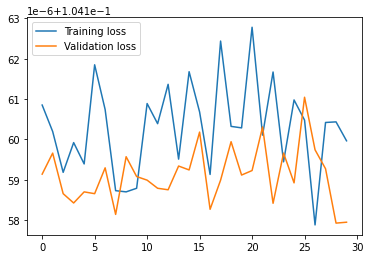

In [32]:
# Check if we have to skip this section
if USE_CACHED_MODEL is False:
        
    # In the start, we have too much error that goes down very fast
    # So we ignore first 5 values for the metric, improving legibility
    # cut = 5
    # training_history["loss"] = training_history["loss"][cut:]
    # training_history["val_loss"] = training_history["val_loss"][cut:]
    
    show_learning_curve(training_history)

## Model evaluation

Show the "criterion" metric on test set

In [33]:
with torch.no_grad():
    net.set_permute(False)
    
    core.test_model_online(net, test_loader, parameters["criterion"], online = True)
    
    net.set_permute(True)

Test Loss: 0.10415811091661453


Now take the classifier from the embedding and use it to compute some classification metrics:

In [34]:
with torch.no_grad():
    
    # Try to clean memory, because we can easily run out of memory
    # This provoke the notebook to crash, and all in-memory objects to be lost
    try_to_clean_memory()
    
    # With hopefully enough memory, try to convert the embedding to a classificator
    classifier = EmbeddingToClassifier(net, k = NUMBER_NEIGHBOURS, data_loader = train_loader, embedding_dimension = EMBEDDING_DIMENSION)

We evaluate this classifier by watching how it works over a small test set. Later we take some metrics from this classifier to evaluate it more precisely.   

In [35]:
with torch.no_grad():

    # Shoow only `max_iterations` classifications
    counter = 0
    max_iterations = 20

    for img, img_class in test_dataset:
        predicted_class = classifier.predict(img)
        print(f"True label: {img_class}, predicted label: {predicted_class[0]}, correct: {img_class == predicted_class[0]}")

        counter += 1
        if counter == max_iterations: break

True label: 7, predicted label: 4, correct: False
True label: 2, predicted label: 3, correct: False
True label: 1, predicted label: 4, correct: False
True label: 0, predicted label: 4, correct: False
True label: 4, predicted label: 1, correct: False
True label: 1, predicted label: 1, correct: True
True label: 4, predicted label: 7, correct: False
True label: 9, predicted label: 6, correct: False
True label: 5, predicted label: 5, correct: True
True label: 9, predicted label: 4, correct: False
True label: 0, predicted label: 0, correct: True
True label: 6, predicted label: 2, correct: False
True label: 9, predicted label: 0, correct: False
True label: 0, predicted label: 8, correct: False
True label: 1, predicted label: 1, correct: True
True label: 5, predicted label: 0, correct: False
True label: 9, predicted label: 4, correct: False
True label: 7, predicted label: 1, correct: False
True label: 3, predicted label: 2, correct: False
True label: 4, predicted label: 8, correct: False


## Plot of the embedding

- If the dimension of the embedding is 2, then we can plot how the transformation to a classificator works:

In [36]:
with torch.no_grad():
    classifier.scatter_plot()

## Evaluating the obtained classifier 

- Now that we adapted our network to a classification task, we can compute some classification metrics

In [37]:
with torch.no_grad():
    try_to_clean_memory()
    classifier.embedder.set_permute(False)
    
    metrics = evaluate_model(classifier, train_loader, test_loader)
    pprint(metrics)
    
    classifier.embedder.set_permute(True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'test_acc': 0.23046875,
 'test_confusion_matrix': array([[58, 19, 12, 13, 12,  8, 10,  7,  4,  5],
       [24, 88, 10,  6,  8,  8,  5,  8,  2,  0],
       [12, 22, 38, 24, 17,  9,  7,  5, 10,  5],
       [18, 16, 35, 57, 16, 12,  3,  4, 10,  5],
       [21, 20, 19, 22, 27,  5, 12,  3, 11, 12],
       [21, 10, 15, 35, 21, 12, 10,  2, 15,  4],
       [17, 30, 18, 12, 22,  4, 30,  1,  2,  4],
       [20, 41, 28, 22, 22,  8, 15, 15,  6,  5],
       [24,  9, 27, 38, 12,  8,  3,  8, 15,  3],
       [24, 15, 24, 11, 23, 12,  9,  3,  3, 14]]),
 'test_roc_auc': 0.6189143485970929,
 'test_silhouette': -0.10072682,
 'train_acc': 0.23161008230452676,
 'train_confusion_matrix': array([[357, 103,  52,  49,  54,  24,  41,  29,  18,   9],
       [ 96, 289,  28,  30,  32,   7,  25,  16,  15,   6],
       [118, 134, 257, 214, 100,  50,  57,  44,  44,  38],
       [105,  54, 176, 288,  54,  27,  27,  32,  76,  25],
       [ 95,  93, 106,  96, 134,  36,  54,  18,  36,  36],
       [ 88,  53,  53,  96,  7